# Inference 

**In this notebook, we will show how to run inference with HEIP model that has been fully trained. And how to benchmark the model**.

Since we have completely re-written the codebase for better reproducibility after the HEIP-model was trained, we need to use a conversion script for the learned weights to match the `cellseg_models.pytorch` library.

In [1]:
import torch
import matplotlib.pyplot as plt
from pathlib import Path
from cellseg_models_pytorch.inference import SlidingWindowInferer
from cellseg_models_pytorch.utils import FileHandler
from src.unet import get_seg_model, convert_state_dict, MODEL_PARTS


unet = get_seg_model()
valid_img_dir = "/path/to/valid_imgs" # MODIFY THIS TO MATCH WHERE YOU HAVE THE VALID SET
save_dir = "/path/to/save_dir" # SET THIS WHERE YOU WANT TO SAVE RESULTING MASKS
path_to_weights = "/path/to/last.ckpt" # MODIFY THIS TO SET THE PATH TO THE TRAINED WEIGHTS 
 
# init the HEIP-model and convert & load the weights
unet = get_seg_model()
ckpt_old = torch.load(path_to_weights, map_location=lambda storage, loc: storage)
new_state_dict = convert_state_dict(
    MODEL_PARTS,
    unet.state_dict(),
    ckpt_old["state_dict"]
)
unet.load_state_dict(new_state_dict, strict=True)


# First we run sliding window inference. 
# The 20 validation results are saved in inferer.out_masks class variable
# NOTE: The runtime and segmentation performance depend heavily on the 
# `stride`` parameter. Here we use a small stride to get the best segmentation perf
# but this sacrifices the performance a little. Also saving to disk is slow.
inferer = SlidingWindowInferer(
    unet,
    valid_img_dir,
    out_activations={"inst": "softmax", "type": "softmax", "omnipose": None},
    out_boundary_weights={"inst": False, "type": False, "omnipose": True},
    patch_size=(256, 256),
    stride=80,
    padding=120,
    instance_postproc="omnipose",
    batch_size=8,
    save_dir=save_dir
)

inferer.infer()

/home/leos/.conda/envs/HEIP/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Running inference: 100%|██████████| 3/3 [01:54<00:00, 38.33s/batch, Saving results to disk]


**Let's plot some results along with their ground truths**

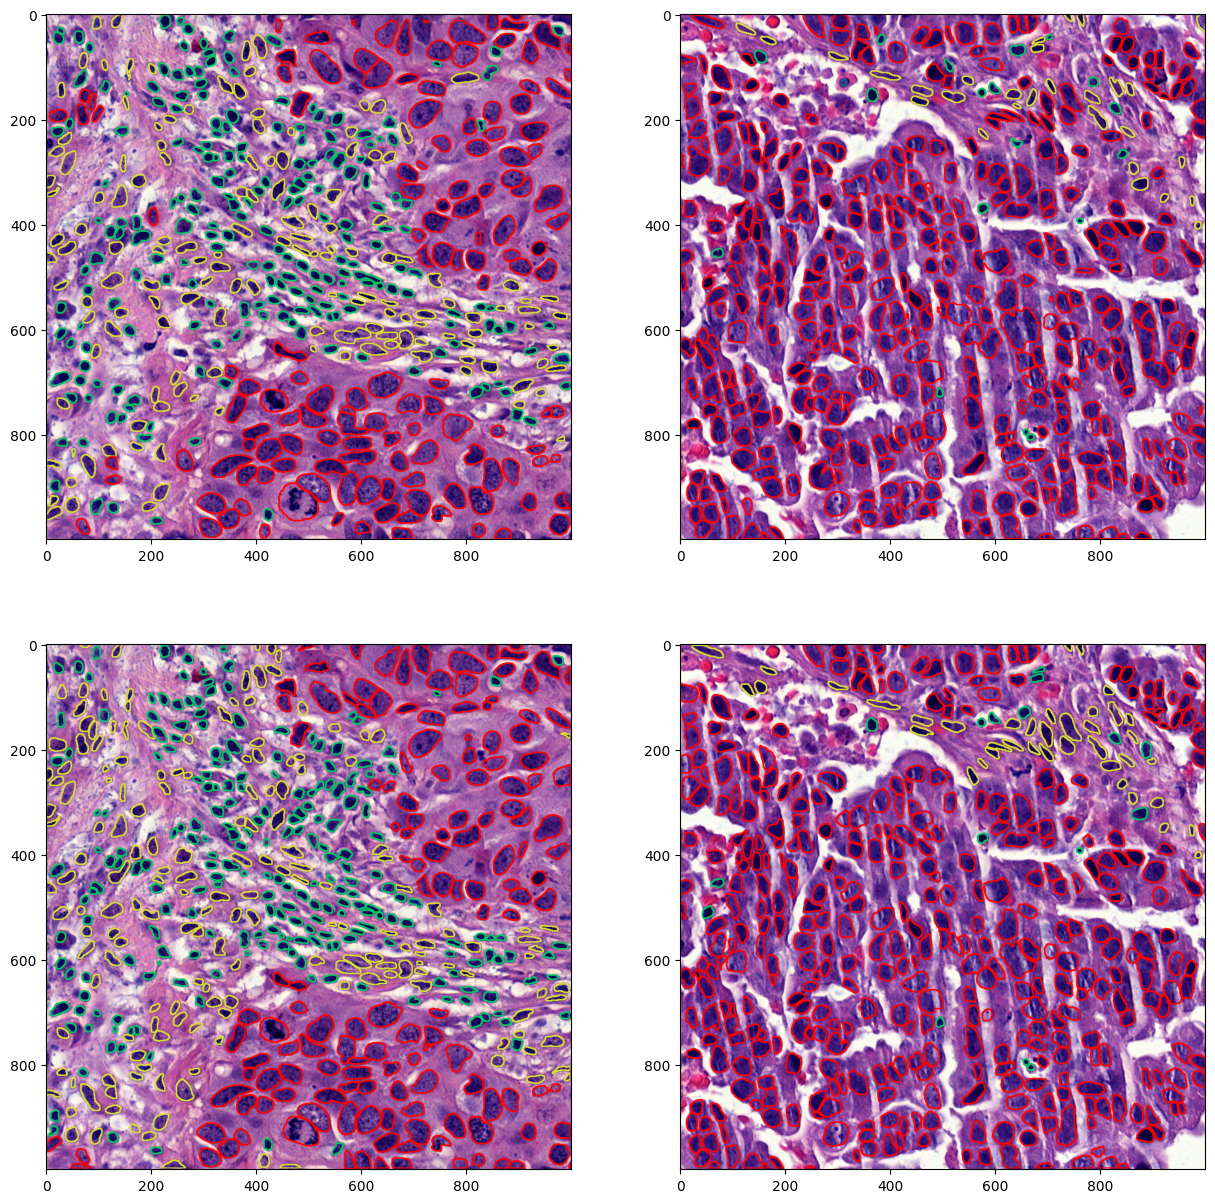

In [8]:
from cellseg_models_pytorch.utils import draw_thing_contours


labdir = Path(save_dir)
imdir = Path(valid_img_dir)
gt_dir = Path("/path/to/gt_dir") # MODIFY THIS TO MATCH YOUR GT DIR

labs = sorted(labdir.glob("*"))
imgs = sorted(imdir.glob("*"))

# Predictions
i1 = 2
masks1 = FileHandler.read_mat(labs[i1], return_all=True)
img1 = FileHandler.read_img(imgs[i1])

i2 = 4
masks2 = FileHandler.read_mat(labs[i2], return_all=True)
img2 = FileHandler.read_img(imgs[i2])


# Ground truths
gt1 = FileHandler.read_mat(gt_dir / labs[i1].name, return_all=True)
gt2 = FileHandler.read_mat(gt_dir / labs[i2].name, return_all=True)

# define the pannuke classes
type_classes = {
    "background": 0,
    "neoplastic": 1,
    "inflammatory": 2,
    "connective": 3,
    "dead": 4,
    "epithelial": 5
}

pred_cells1 = draw_thing_contours(masks1["inst_map"], img1, masks1["type_map"], classes=type_classes)
pred_cells2 = draw_thing_contours(masks2["inst_map"], img2, masks2["type_map"], classes=type_classes)
gt_cells1 = draw_thing_contours(gt1["inst_map"], img1, gt1["type_map"], classes=type_classes)
gt_cells2 = draw_thing_contours(gt2["inst_map"], img2, gt2["type_map"], classes=type_classes)


fig, ax = plt.subplots(2, 2, figsize=(15, 15))
ax = ax.flatten()
ax[0].imshow(pred_cells1)
ax[1].imshow(pred_cells2)
ax[2].imshow(gt_cells1)
ax[3].imshow(gt_cells2)

# Benchmarking

The results look ok by eye-balling but let's get some numbers for them too.

Here, we will be computing the **panoptic quality (PQ)** and **average precision (AP)** for every cell type separately for each of the validation images.

**NOTE:** We omit the dead cell class (one of Pannuke classes) since our validation dataset does not contain dead cells.

In [5]:
from cellseg_models_pytorch.utils.seg_benchmark import BenchMarker
import pandas as pd


bm = BenchMarker(save_dir, gt_dir, type_classes)
met = bm.run_inst_benchmark(how="multi", metrics=("pq", "ap"))
met = pd.DataFrame(met)

Running epithelial instance seg metrics: 100%|██████████| 20/20 [00:02<00:00,  7.19it/s]


In [6]:
met.groupby("type").mean(numeric_only=True).drop("dead")

,pq,sq,dq,ap
type,,,,
connective,0.533167,0.830224,0.642455,0.681005
epithelial,0.685155,0.866931,0.790487,0.894948
inflammatory,0.500872,0.852067,0.586059,0.643604
neoplastic,0.665123,0.860498,0.772265,0.812907
